In [1]:
# Importing all required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
#Importing Dataset

df_main = pd.read_csv("./data/HRDataset_v14.csv")
#Making a set of colums from dataset which are categorical, not numerical
categorical = set(('Employee_Name','Position', 'State', 'Zip', 'DOB', 'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination','TermReason' ,'EmploymentStatus', 'Department', 'ManagerName', 'RecruitmentSource', 'PerformanceScore', 'LastPerformanceReview_Date' ))


group_columns = ['EmpID', 'Salary']
sensitive_column = 'Employee_Name'
df_main.head()


,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2


In [3]:
#Defining required basic functions 

def split(df, partition, column):
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

def get_spans(df, partition, scale=None):
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

def partition_dataset(df, group_columns, sensitive_column, scale, is_valid):
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[group_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [4]:
#k-Anonymity functions 

def is_k_anonymous(df, partition, sensitive_column, k=3):
    if len(partition) < k:
        return False
    return True

In [5]:
#l-Diversity functions
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=2):
    return diversity(df, partition, sensitive_column) >= l


In [6]:
#t-Closeness functions
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.2):
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

global_freqs = {}
total_count = float(len(df_main))
group_counts = df_main.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p


In [7]:
#Code for merging and actually making Dataset
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

def build_anonymized_dataset(df, partitions, group_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in group_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [8]:
#Defining global variables as required 
full_spans = get_spans(df_main, df_main.index)


In [9]:
#Actually implement k-Anonymity, l-Diversity and t-Closeness 
k_partitions = partition_dataset(df_main, group_columns, sensitive_column, full_spans, is_k_anonymous)
l_partitions = partition_dataset(df_main, group_columns, sensitive_column, full_spans, lambda *args: is_l_diverse(*args))
#TODO: Use a categorical sensitive column
t_partitions = partition_dataset(df_main, group_columns, sensitive_column, full_spans, lambda *args: is_t_close(*args, global_freqs))

In [10]:
# Actually make dataset by merging partitions 
df_k = build_anonymized_dataset(df_main, k_partitions, group_columns, sensitive_column)
df_l = build_anonymized_dataset(df_main, l_partitions, group_columns, sensitive_column)
df_t = build_anonymized_dataset(df_main, t_partitions, group_columns, sensitive_column)

Finished 1 partitions...
Finished 1 partitions...
Finished 101 partitions...
Finished 1 partitions...


In [11]:
#Functions for Visualizing Data
def build_indexes(df):
    indexes = {}
    for column in categorical_drop:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical_drop:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical_drop:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

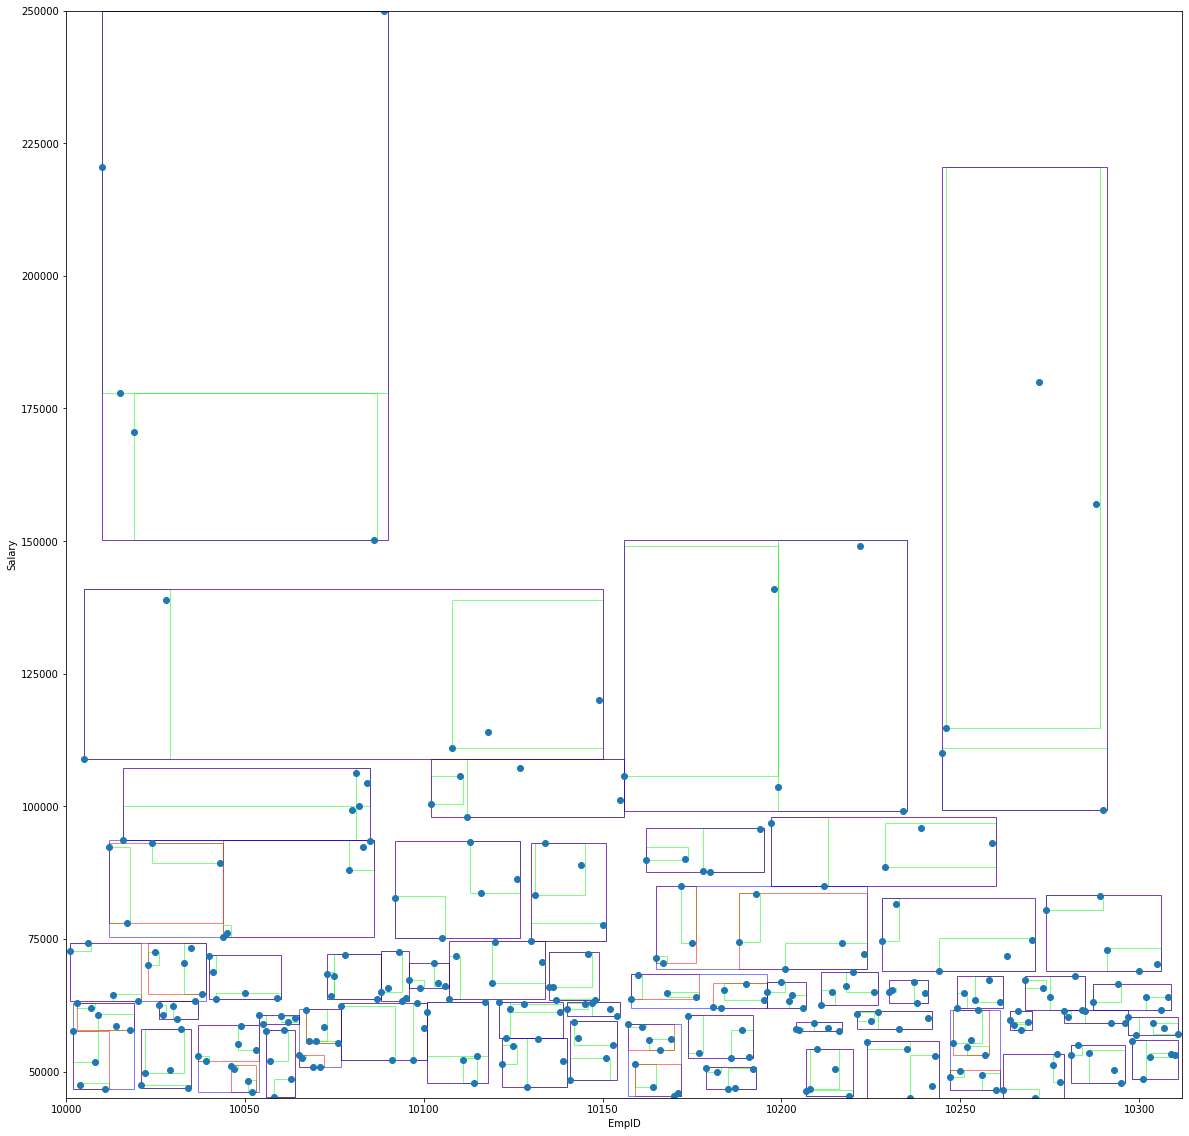

In [12]:
categorical_drop = set(('Employee_Name','Position', 'State', 'Zip', 'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc','TermReason' ,'EmploymentStatus', 'Department', 'ManagerName', 'RecruitmentSource', 'PerformanceScore' ))
df_main.drop('DOB', axis=1, inplace=True)
df_main.drop('LastPerformanceReview_Date',  axis=1, inplace=True)
df_main.drop('DateofTermination', axis=1, inplace=True)
df_main.drop('DateofHire',  axis=1, inplace=True)

indexes = build_indexes(df_main)
column_x, column_y = group_columns[:2]

rects_of_k = get_partition_rects(df_main, k_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])
rects_of_l = get_partition_rects(df_main, l_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])
rects_of_t = get_partition_rects(df_main, t_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)
    
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
plot_rects(df_main, ax, rects_of_l, column_x, column_y, edgecolor='#00ff00')
plot_rects(df_main, ax, rects_of_k, column_x, column_y, edgecolor='#ff0000')
plot_rects(df_main, ax, rects_of_t, column_x, column_y, edgecolor='#0000ff')


plt.scatter(df_main[column_x], df_main[column_y])
plt.show()

In [41]:
df_k.groupby("RecruitmentSource").size()

,EmpID,Salary,Employee_Name,count
0,[10006.25],[50879.25],"Anderson, Linda",1
1,[10006.25],[50879.25],"Lindsay, Leonara",1
2,[10006.25],[50879.25],"Lynch, Lindsay",1
3,[10006.25],[50879.25],"Rivera, Haley",1
4,[10010.2],[60407.4],"Billis, Helen",1
